In [1]:
#get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import pandas as pd
#!pip install nolds
#!pip install git+https://github.com/neuropsychology/NeuroKit.py#egg=neurokit
from pandas import ExcelWriter
from pandas import ExcelFile
import os , sys
import glob
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import norm
import matplotlib.mlab as mlab
#import neurokit as nk
# get_ipython().system('git clone https://github.com/davidhallac/TICC.git')
# from TICC_solver import TICC
import re
import seaborn as sns
import nolds
plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
#cwd = os.path.normpath(os.getcwd() + os.sep + os.pardir)
cwd = os.path.normpath(os.getcwd())


# In[2]:


def get_labels(bins, thermolist, column = 'Label'):
    trajs_in_bins = {}
    for b in bins:
        trajs_in_bins[b] = []
        for t in range(len(thermolist['Trial'])):
            if thermolist['Label'][t] == b:
                trajs_in_bins[b].append(int(thermolist['Trial'][t]))
    return trajs_in_bins

def import_trajectories(bins, trajs_in_bins): 
    files = glob.glob('*[0-9].txt*')
    raw_traj = {}
    all_traj = {}
    for file in files:
        raw_traj[file[:-4]] = np.loadtxt(file, dtype='i', delimiter=',')
    traj_binned_raw = {}
    #bins = ['cont', 'heat','cont_RRed','heat_RRed','cont_higherFrameRate','heat_higherFrameRate']
    for b in bins:
        traj_binned_raw[b] = {}
    #For now, ignore the size and perimeter data and just look at centroid position.
    for key in raw_traj.keys():
        for bin_name in bins:
            if re.match('^[0-9]*$', key): 
                if int(key) in trajs_in_bins[bin_name]:
                    traj_binned_raw[bin_name][key] = raw_traj[key][:,0:2]
                    all_traj[key] = raw_traj[key]
                    break
            else: 
                break
    return traj_binned_raw, all_traj

def get_excel_info(excel_info, thermolist, bins, binned_keys, printinfo = 'on'):
    traj_info = {}
    
    for b in bins:
        traj_info[b] = {}
   
        for item in excel_info:
            traj_info[b][item] = {}
            for key in binned_keys[b]:
                key = str(key)
                trialnum = int(key)
                indlist = np.where(thermolist['Trial'] == trialnum)
                ind = indlist[0][0]   
                #print(thermolist[item][ind])
                if thermolist[item][ind] > 0:
                    traj_info[b][item][key] = thermolist[item][ind]
                else:
                    if printinfo == 'on':
                        print('Invalid value found for key: ' + str(key) + ', Bin: ' + b + ', Item: ' + item)
    
    return traj_info
def Swap(arr, start_index, last_index):
    arr[:, [start_index, last_index]] = arr[:, [last_index, start_index]]
def convert_traj (thermolist, traj_info, bins, traj_binned_raw, L_unit = 'mm', t_unit = 'min'):
    traj_binned = {}
    for b in bins: 
        traj_binned[b] = {}
        for key in traj_binned_raw[b].keys(): 
            temp1 = traj_binned_raw[b][key] 
            fr = traj_info[b]['FR'][key]      
        
            
            traj_binned[b][key] = np.zeros((len(temp1[:,0]),3))
            trialnum = int(key)
            indlist = np.where(thermolist['Trial'] == trialnum)
            ind = indlist[0][0]
            pixel_conv = thermolist['Pixel Conversion'][ind]
            axis = thermolist['Axis'][ind]
            camnum = thermolist['Cam'][ind]
            #print(camnum)
            if pixel_conv != 0:
                print('px conv:', pixel_conv, ' trial: ', key)
                temp1 = temp1 * pixel_conv #Si Wafer PVC pipe setup, cam2 with hot plate

            elif camnum == 1:
                temp1 = temp1 * 50800/1864000  #Si Wafer PVC pipe setup
            elif camnum ==2:
                temp1 = temp1 * 50800/966000 #Si Wafer PVC pipe setup
            elif camnum ==3:
                temp1 = temp1 * 50800/834000 #Si Wafer PVC pipe setup
            else:
                continue
            
        
            if axis == 'yp':
                temp1[:,1] = temp1[:,1] * -1
            elif axis == 'xp':
                Swap(temp1, 0, 1)
                temp1[:,1] = temp1[:,1] * -1
            elif axis == 'xn':
                Swap(temp1, 0, 1)
                #Third column is time
            traj_binned[b][key][:,2] = np.linspace(0,fr/60*(len(temp1[:,0])-1),len(temp1[:,0]))    
            traj_binned[b][key][:,:2] = temp1        
    
    return traj_binned

def compile_for_plotting(excel_info, traj_info, bins):
    
    toplot = {}
    
    for param in excel_info:
        toplot[param] = {}
        for b in bins: 
            toplot[param][b] = list(traj_info[b][param].values())
    return toplot
        
def plot_per_bin (x,y, colorarray, bins, cmaps = ['Blues', 'Reds', 'Purples','bone'], plot_type = 'scatter',y_caption = ''):
    Fig_name = plt.figure()
    ax = Fig_name.gca()    
    if plot_type == 'scatter':
        count = 0
        for b in bins: 
            plt.scatter(x[b], y[b], c = colorarray[b],cmap = cmaps[count])
            cbar = plt.colorbar()
            cbar.set_label('Bin:' + b)
            count += 1
        ax.set_ylabel(y_caption, fontsize = 18)
    elif plot_type == 'boxplot':
        boxplot_x = [b for b in bins]
        boxplot_data = [x[b] for b in bins]
        sns.boxplot(data=boxplot_data, palette="Set3")
        sns.swarmplot(data=boxplot_data, color=".25")
        plt.xticks([0,1],boxplot_x)
        ax.set_ylabel(y_caption, fontsize = 18)
    return Fig_name, ax


# ### Sliding window velocity functions with variable window size 

# In[3]:


def V_overlapping_windows(bins, all_w,traj_binned, traj_info):

    V = {}

    for b in bins:    
        V[b] = {}
        for w in all_w: 
            V[b][w] = {}
            for key in traj_binned[b].keys():
                L = len(traj_binned[b][key][:,1])-2*w
                V[b][w][key] = np.zeros((L,16))   
                #Abs displacement, velocity, persistence velocity, turning velocity, angle, angle2, 
                #y dir velocity, x dir velocity, y dir acceleration, x dir acceleration, WHETHER TO REMOVE!, 
                #y displacement, x displacement, cos(turning anlge), sin(turning angle)
                temp = traj_binned[b][key]    
                for i in range(L):   
                    dx1 = temp[i+w, 0]  - temp[i, 0]
                    dx2 = temp[i+2*w, 0]  - temp[i+w, 0]
                    dy1 = temp[i+w, 1]  - temp[i, 1]
                    dy2 = temp[i+2*w, 1]  - temp[i+w, 1] 
                    x0 = temp[i,0]
                    y0 = temp[i,1]
                    x1 = temp[i+w, 0]
                    y1 = temp[i+w, 1]
                    x2 = temp[i+2*w, 0]
                    y2 = temp[i+2*w, 1]

                    #Angles wrt positive x axis
    #                 angle1 = np.arctan2(dy1,dx1)
    #                 angle2 = np.arctan2(dy2,dx2)                


                   #Angles wrt positive y axis

                    angle1 = np.arctan2(dx1,dy1)
                    angle2 = np.arctan2(dx2,dy2)

                    dot = np.dot(np.array([dx1,dy1]),np.array([dx2,dy2]))
                    norma = np.linalg.norm(np.array([dx1,dy1]))
                    normb = np.linalg.norm(np.array([dx2,dy2]))


                    if (norma * normb) == 0:
                        angle = 0
                        angle_turning = 0
                        V[b][w][key][i,10] = 1
                    else:
                        cos_theta = dot / (norma * normb)
                        V[b][w][key][i,10] = 0
                        if cos_theta < -1 or cos_theta > 1:
                            cos_theta = np.round(cos_theta,5)


                        angle = np.arccos(cos_theta)
                        angle_turning = angle2-angle1





                    V[b][w][key][i,0] = np.sqrt((y2-y1)**2+(x2-x1)**2)

                    #SPECIFY FRAME RATE
                    framerate = traj_info[b]['FR'][key]

                    V[b][w][key][i,1] = V[b][w][key][i,0]/ (framerate/60*w)  #mm/min
                    V[b][w][key][i,2] = V[b][w][key][i,1] * np.cos(angle)
                    V[b][w][key][i,3] = V[b][w][key][i,1] * np.sin(angle)
                    V[b][w][key][i,4] = angle
                    V[b][w][key][i,5] = angle2
                    #Expect the biased trials to have negative y velocity
                    V[b][w][key][i,6] = (y2-y1)/(framerate/60*w)
                    V[b][w][key][i,7] = (x2-x1)/(framerate/60*w)
                    V[b][w][key][i,8] = (dy2-dy1)/(framerate/60*w)**2
                    V[b][w][key][i,9] = (dx2-dx1)/(framerate/60*w)**2
                    V[b][w][key][i,11] = dy2
                    V[b][w][key][i,12] = dx2
                    V[b][w][key][i,13] = np.cos(angle_turning)
                    V[b][w][key][i,14] = np.sin(angle_turning)
                    V[b][w][key][i,15] = angle_turning
    return V

def V_nonoverlapping_windows(bins, all_w,traj_binned, traj_info):
    
    V = {}

    for b in bins:    
        V[b] = {}
        for w in all_w: 
            V[b][w] = {}
            for key in traj_binned[b].keys():
                L = int(np.floor(len(traj_binned[b][key][:,1])/w - 2*w))
                V[b][w][key] = np.zeros((L,16))   
                #Abs displacement, velocity, persistence velocity, turning velocity, angle, angle2, 
                #y dir velocity, x dir velocity, y dir acceleration, x dir acceleration, WHETHER TO REMOVE!, 
                #y displacement, x displacement, cos(turning anlge), sin(turning angle)
                temp = traj_binned[b][key]    
                for i in range(L):   
                    dx1 = temp[i*w + w, 0]  - temp[i*w, 0]
                    dx2 = temp[i*w+2*w, 0]  - temp[i*w+w, 0]
                    dy1 = temp[i*w+w, 1]  - temp[i*w, 1]
                    dy2 = temp[i*w+2*w, 1]  - temp[i*w+w, 1] 
                    x0 = temp[i*w,0]
                    y0 = temp[i*w,1]
                    x1 = temp[i*w+w, 0]
                    y1 = temp[i*w+w, 1]
                    x2 = temp[i*w+2*w, 0]
                    y2 = temp[i*w+2*w, 1]

                    #Angles wrt positive x axis
    #                 angle1 = np.arctan2(dy1,dx1)
    #                 angle2 = np.arctan2(dy2,dx2)                


                   #Angles wrt positive y axis

                    angle1 = np.arctan2(dx1,dy1)
                    angle2 = np.arctan2(dx2,dy2)

                    dot = np.dot(np.array([dx1,dy1]),np.array([dx2,dy2]))
                    norma = np.linalg.norm(np.array([dx1,dy1]))
                    normb = np.linalg.norm(np.array([dx2,dy2]))


                    if (norma * normb) == 0:
                        angle = 0
                        angle_turning = 0
                        V[b][w][key][i,10] = 1
                    else:
                        cos_theta = dot / (norma * normb)
                        V[b][w][key][i,10] = 0
                        if cos_theta < -1 or cos_theta > 1:
                            cos_theta = np.round(cos_theta,5)


                        angle = np.arccos(cos_theta)
                        
                        angle_turning = angle2-angle1





                    V[b][w][key][i,0] = np.sqrt((y2-y1)**2+(x2-x1)**2)

                
                    #SPECIFY FRAME RATE
                    framerate = traj_info[b]['FR'][key]

                    V[b][w][key][i,1] = V[b][w][key][i,0]/ (framerate/60*w)  #mm/min
                    V[b][w][key][i,2] = V[b][w][key][i,1] * np.cos(angle)
                    V[b][w][key][i,3] = V[b][w][key][i,1] * np.sin(angle)
                    V[b][w][key][i,4] = angle
                    V[b][w][key][i,5] = angle2
                    #Expect the biased trials to have negative y velocity
                    V[b][w][key][i,6] = (y2-y1)/(framerate/60*w)
                    V[b][w][key][i,7] = (x2-x1)/(framerate/60*w)
                    V[b][w][key][i,8] = (dy2-dy1)/(framerate/60*w)**2
                    V[b][w][key][i,9] = (dx2-dx1)/(framerate/60*w)**2
                    V[b][w][key][i,11] = dy2
                    V[b][w][key][i,12] = dx2
                    V[b][w][key][i,13] = np.cos(angle_turning)
                    V[b][w][key][i,14] = np.sin(angle_turning)
                    V[b][w][key][i,15] = angle_turning
                    
    return V

def y_dir_index (V, w, bins, traj_binned):
    y_dir = {}
    for b in bins: 
        y_dir[b] = []
        for key in traj_binned[b].keys():
            y_dir[b].append(np.sum(-(V[b][w][key][:,11]))/np.sum(V[b][w][key][:,0])) 
    return y_dir



In [2]:
import seaborn as sns
print(cwd)
bins = ['Drug']
thermolist = pd.read_excel(cwd+'/Experiment_List.xlsx', sheet_name='Sheet1')

binned_keys = get_labels(bins, thermolist)
washout_keys = get_labels(['Washout'], thermolist)


traj_binned_raw, all_traj = import_trajectories(bins, binned_keys)
traj_washout_raw, all_traj_washout = import_trajectories(['Washout'], washout_keys)



excel_info = ['T1', 'T2', 'FR','Cam', 'Frame Naringenin Added','Frame FFA Added', 'Frame Hesperetin Added','Frame Water Added', 'Frame DMSO added']
washout_excel_info = ['FR', 'Cam']

traj_info = get_excel_info(excel_info, thermolist, bins, binned_keys, printinfo = 'off')
traj_info_washout = get_excel_info(washout_excel_info, thermolist, ['Washout'], washout_keys, printinfo = 'off')

traj_binned = convert_traj (thermolist, traj_info, bins, traj_binned_raw)
washout_traj_binned = convert_traj (thermolist, traj_info_washout, ['Washout'], traj_washout_raw)

compilation = compile_for_plotting(excel_info, traj_info, bins)
 

all_w = [1,3]
V = V_nonoverlapping_windows(bins, all_w,traj_binned, traj_info)
V_overlap = V_overlapping_windows(bins, all_w,traj_binned, traj_info)
V_washout = V_nonoverlapping_windows(['Washout'], all_w,washout_traj_binned, traj_info_washout)



/Users/ilikecookiee/Documents/Prakashlab/Thermo_Trajectories/Paper_Repository_Clean
px conv: 0.030260403458213257  trial:  289
px conv: 0.030260403458213257  trial:  262
px conv: 0.030260403458213257  trial:  261
px conv: 0.030260403458213257  trial:  283
px conv: 0.030260403458213257  trial:  286
px conv: 0.030260403458213257  trial:  287
px conv: 0.030260403458213257  trial:  285
px conv: 0.030260403458213257  trial:  291
px conv: 0.030260403458213257  trial:  284


/Users/ilikecookiee/opt/anaconda3/envs/prakashlab/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ilikecookiee/opt/anaconda3/envs/prakashlab/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ilikecookiee/opt/anaconda3/envs/prakashlab/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ilikecookiee/opt/anaconda3/envs/prakashlab/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


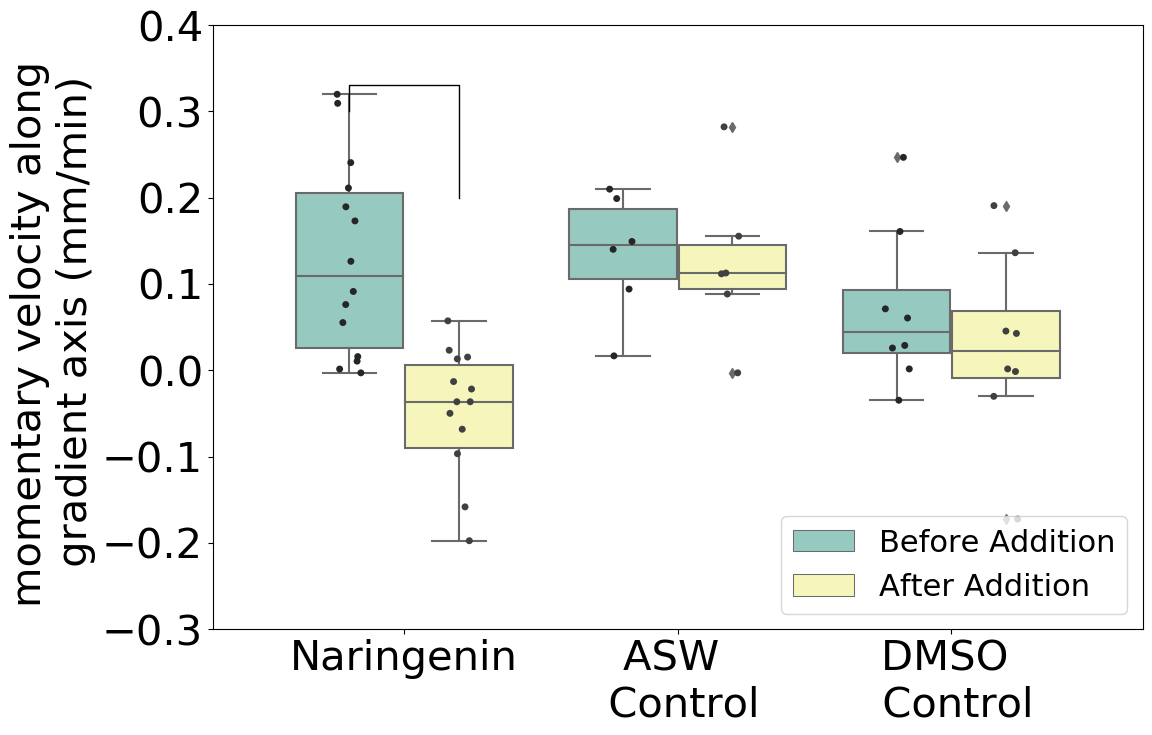

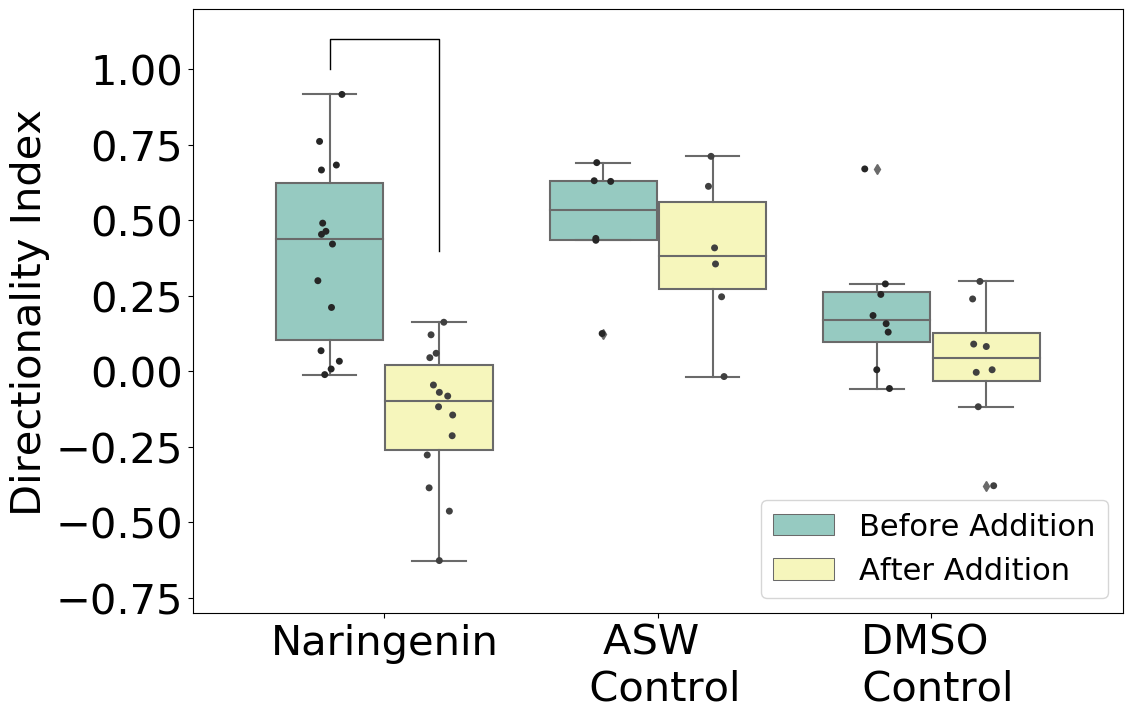

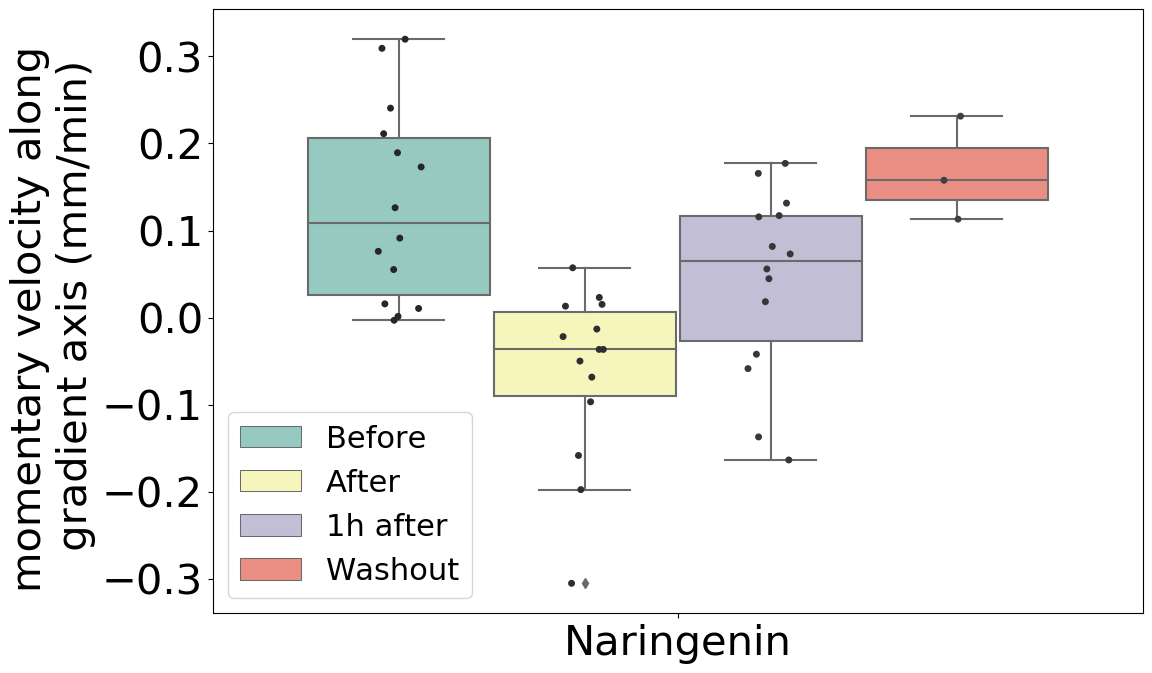

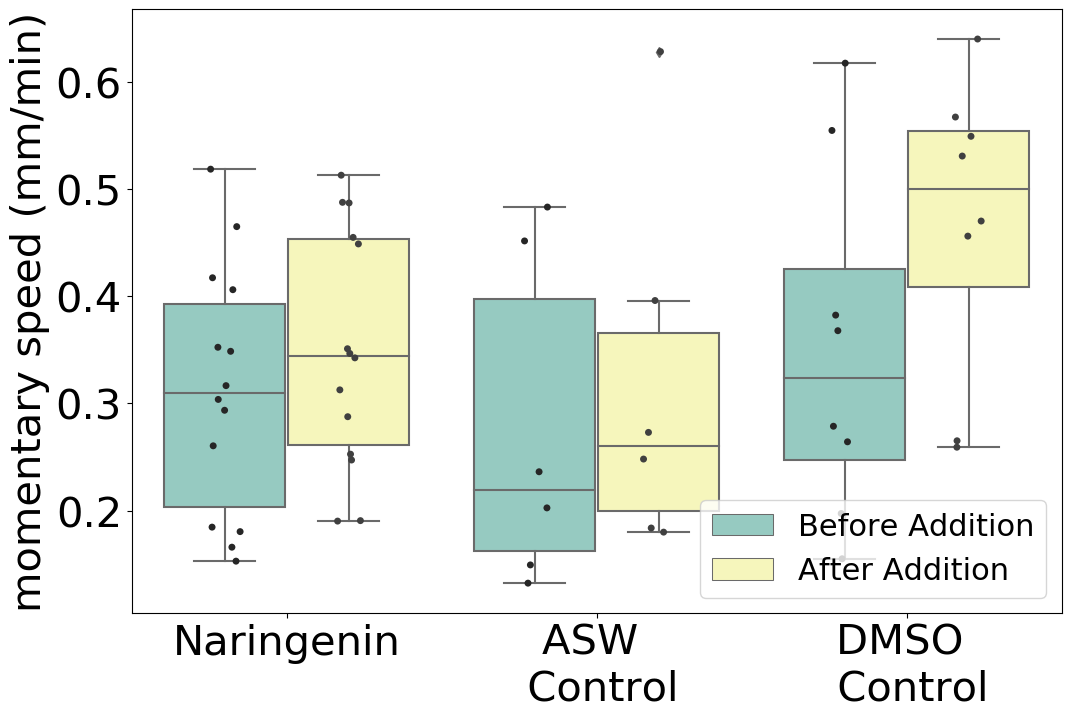

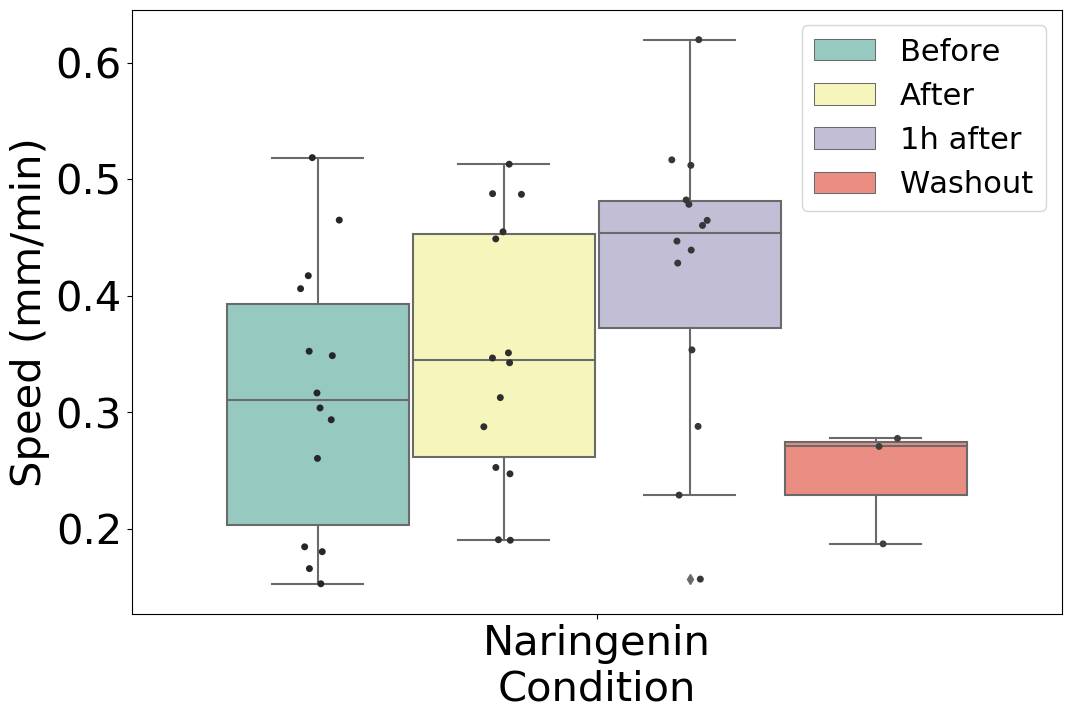

In [3]:
all_w = [1]   
#y velocity boxplots            

V_concat = {}
V_concat_directionality = {}
V_drug = {}
x = 40
col_interest = 6

#washout
V_drug['Washout'] = []
for w in all_w:
    for key in traj_info_washout['Washout']['FR'].keys():
        fr = traj_info_washout['Washout']['FR'][key]
        Vtemp = V_washout['Washout'][w][key][:,col_interest]
        Vwashout = -np.mean(Vtemp[0:x//w])
        V_drug['Washout']. append(Vwashout)
        
        
for b in bins:
    for w in all_w:
        
        V_concat['Before'] = []
        V_concat['After'] = []
        V_concat['Hue'] = []
        
        V_concat_directionality['Before'] = []
        V_concat_directionality['After'] = []
        V_concat_directionality['Hue'] = []    
        
        V_drug['Before'] = []
        V_drug['After'] = []
        V_drug['1 hr post addition'] = []
        V_drug['2 hr post addition'] = []
        V_drug['Hue'] =[]
        
        
        for key in traj_info[b]['Frame Naringenin Added'].keys():
            addition = int(traj_info[b]['Frame Naringenin Added'][key])
            fr = traj_info[b]['FR'][key]
            
            Vtemp = V[b][w][key][:,col_interest]
            #get the mean y velocity for x pts before and x pts after addition
            Vbefore = -np.mean(Vtemp[addition//w-x//w:addition//w])
            Vafter = -np.mean(Vtemp[addition//w:addition//w+x//w])
            Vafter_2 = -np.mean(Vtemp[addition//w+2*x//w: addition//w+3*x//w])
            Vafter_3 = -np.mean(Vtemp[addition//w+4*x//w: addition//w+5*x//w])
            
            #directionality index before and after addi
            y_directionality_before = (np.sum(-(V[b][w][key][addition//w-x//w:addition//w,11]))/np.sum(V[b][w][key][addition//w-x//w:addition//w,0])) 
            y_directionality_after = (np.sum(-(V[b][w][key][addition//w:addition//w+x//w,11]))/np.sum(V[b][w][key][addition//w:addition//w+x//w,0]))             
            
            V_concat['Before'].append(Vbefore)
            V_concat['After'].append(Vafter) 
            V_concat['Hue']. append('Naringenin')
            
            V_concat_directionality['Before'].append(y_directionality_before)
            V_concat_directionality['After'].append(y_directionality_after) 
            V_concat_directionality['Hue']. append('Naringenin')
            
            V_drug['Before'].append(Vbefore)
            V_drug['After'].append(Vafter)             
            V_drug['1 hr post addition'].append(Vafter_2)
            V_drug['2 hr post addition'].append(Vafter_3)
            V_drug['Hue']. append('Naringenin')
        for key in traj_info[b]['Frame Hesperetin Added'].keys():

            addition = int(traj_info[b]['Frame Hesperetin Added'][key])
            fr = traj_info[b]['FR'][key]
            
            Vtemp = V[b][w][key][:,col_interest]
            #get the mean y velocity for x pts before and x pts after addition
            Vbefore = -np.mean(Vtemp[addition//w-x//w:addition//w])
            Vafter = -np.mean(Vtemp[addition//w:addition//w+x//w])
            #Didn't record this condition for long enough....
            #Vafter_2 = np.mean(Vtemp[addition//w+2*x//w: addition//w+3*x//w])
            
            #directionality index before and after addi
            y_directionality_before = (np.sum(-(V[b][w][key][addition//w-x//w:addition//w,11]))/np.sum(V[b][w][key][addition//w-x//w:addition//w,0])) 
            y_directionality_after = (np.sum(-(V[b][w][key][addition//w:addition//w+x//w,11]))/np.sum(V[b][w][key][addition//w:addition//w+x//w,0]))             
            
            V_concat_directionality['Before'].append(y_directionality_before)
            V_concat_directionality['After'].append(y_directionality_after) 
            V_concat_directionality['Hue']. append('Hesperetin')
                       
            
            
            V_concat['Before'].append(Vbefore)
            V_concat['After'].append(Vafter) 
            V_concat['Hue']. append('Hesperetin') 
        for key in traj_info[b]['Frame FFA Added'].keys():

            addition = int(traj_info[b]['Frame FFA Added'][key])
            fr = traj_info[b]['FR'][key]
            
            Vtemp = V[b][w][key][:,col_interest]
            #get the mean y velocity for x pts before and x pts after addition
            Vbefore = -np.mean(Vtemp[addition//w-x//w:addition//w])
            Vafter = -np.mean(Vtemp[addition//w:addition//w+x//w])
            #Didn't record this condition for long enough....
            #Vafter_2 = np.mean(Vtemp[addition//w+2*x//w: addition//w+3*x//w])
            
            #directionality index before and after addi
            y_directionality_before = (np.sum(-(V[b][w][key][addition//w-x//w:addition//w,11]))/np.sum(V[b][w][key][addition//w-x//w:addition//w,0])) 
            y_directionality_after = (np.sum(-(V[b][w][key][addition//w:addition//w+x//w,11]))/np.sum(V[b][w][key][addition//w:addition//w+x//w,0]))             
            
#             V_concat_directionality['Before'].append(y_directionality_before)
#             V_concat_directionality['After'].append(y_directionality_after) 
#             V_concat_directionality['Hue']. append('FFA')
                        
#             V_concat['Before'].append(Vbefore)
#             V_concat['After'].append(Vafter) 
#             V_concat['Hue']. append('FFA') 
            
        for key in traj_info[b]['Frame Water Added'].keys():

            addition = int(traj_info[b]['Frame Water Added'][key])
            fr = traj_info[b]['FR'][key]
            
            Vtemp = V[b][w][key][:,col_interest]
            #get the mean y velocity for x pts before and x pts after addition
            Vbefore = -np.mean(Vtemp[addition//w-x//w:addition//w])
            Vafter = -np.mean(Vtemp[addition//w:addition//w+x//w])
            #Didn't record this condition for long enough....
            #Vafter_2 = np.mean(Vtemp[addition//w+2*x//w: addition//w+3*x//w])
            
            #directionality index before and after addi
            y_directionality_before = (np.sum(-(V[b][w][key][addition//w-x//w:addition//w,11]))/np.sum(V[b][w][key][addition//w-x//w:addition//w,0])) 
            y_directionality_after = (np.sum(-(V[b][w][key][addition//w:addition//w+x//w,11]))/np.sum(V[b][w][key][addition//w:addition//w+x//w,0]))             

            
            V_concat_directionality['Before'].append(y_directionality_before)
            V_concat_directionality['After'].append(y_directionality_after) 
            V_concat_directionality['Hue']. append('ASW \n Control')
                        
            V_concat['Before'].append(Vbefore)
            V_concat['After'].append(Vafter) 
            V_concat['Hue']. append('ASW \n Control')

            
        for key in traj_info[b]['Frame DMSO added'].keys():

            addition = int(traj_info[b]['Frame DMSO added'][key])
            fr = traj_info[b]['FR'][key]
            
            Vtemp = V[b][w][key][:,col_interest]
            #get the mean y velocity for x pts before and x pts after addition
            Vbefore = -np.mean(Vtemp[addition//w-x//w:addition//w])
            Vafter = -np.mean(Vtemp[addition//w:addition//w+x//w])
            #Didn't record this condition for long enough....
            #Vafter_2 = np.mean(Vtemp[addition//w+2*x//w: addition//w+3*x//w])
            
            #directionality index before and after addi
            y_directionality_before = (np.sum(-(V[b][w][key][addition//w-x//w:addition//w,11]))/np.sum(V[b][w][key][addition//w-x//w:addition//w,0])) 
            y_directionality_after = (np.sum(-(V[b][w][key][addition//w:addition//w+x//w,11]))/np.sum(V[b][w][key][addition//w:addition//w+x//w,0]))             
            
            
            V_concat_directionality['Before'].append(y_directionality_before)
            V_concat_directionality['After'].append(y_directionality_after) 
            V_concat_directionality['Hue']. append('DMSO \n Control')
            
            
            V_concat['Before'].append(Vbefore)
            V_concat['After'].append(Vafter) 
            V_concat['Hue']. append('DMSO \n Control')
            
        boxplot_data = np.column_stack((V_concat['Before'], V_concat['After'],V_concat['Hue']))
        boxplot_data_directionality = np.column_stack((V_concat_directionality['Before'], V_concat_directionality['After'],V_concat_directionality['Hue']))

        df = pd.DataFrame(boxplot_data,  columns = ['Before Addition', 'After Addition', 'Condition'])
        df_long = pd.melt(df, "Condition", var_name="Time", value_name="Y Velocity")
        df_long = df_long.astype({'Y Velocity': 'float'})

        df_dir = pd.DataFrame(boxplot_data_directionality,  columns = ['Before Addition', 'After Addition', 'Condition'])
        df_long_dir = pd.melt(df_dir, "Condition", var_name="Time", value_name="Y Velocity")
        df_long_dir = df_long_dir.astype({'Y Velocity': 'float'})        
        
        plt.figure()
        ax1 = sns.boxplot(x = 'Condition', y = 'Y Velocity' , hue = "Time", data=df_long, palette="Set3")
        ax1 = sns.stripplot(x = 'Condition', y = 'Y Velocity' , hue = "Time", data=df_long, color = '0.25', dodge = 'True')
        #plt.title('Mean Y Velocity Before & After Addition')
        handles, labels = ax1.get_legend_handles_labels()
        l = plt.legend(handles[0:2], labels[0:2],fontsize = 22, loc = 'lower right')
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.ylim([-0.3,0.4])
        plt.plot([-0.2,-0.2, 0.2, 0.2], [0.3, 0.33, 0.33, 0.2], linewidth=1, color='k')
        plt.ylabel('momentary velocity along \n gradient axis (mm/min)', fontsize = 30)
        plt.xlabel('')
        title = 'Drug_Velocity.png'
        plt.savefig(cwd+'/PaperFigs/fig4 naringenin compilation/' + title, bbox_inches="tight")  

        plt.figure()
        ax1 = sns.boxplot(x = 'Condition', y = 'Y Velocity' , hue = "Time", data=df_long_dir, palette="Set3")
        ax1 = sns.stripplot(x = 'Condition', y = 'Y Velocity' , hue = "Time", data=df_long_dir, color = '0.25', dodge = 'True')
        #plt.title('Mean Y Velocity Before & After Addition')
        handles, labels = ax1.get_legend_handles_labels()
        l = plt.legend(handles[0:2], labels[0:2],fontsize = 22, loc = 'lower right')
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.ylim([-0.8,1.2])
        plt.plot([-0.2,-0.2, 0.2, 0.2], [1, 1.1, 1.1, 0.4], linewidth=1, color='k')
        plt.ylabel('Directionality Index', fontsize = 30)
        plt.xlabel('')
        title = 'Drug_Directionality_Index.png'
        plt.savefig(cwd+'/PaperFigs/fig4 naringenin compilation/' + title, bbox_inches="tight")  
        
        plt.figure()
        box_drug = np.column_stack((V_drug['Before'],V_drug['After'],V_drug['1 hr post addition'],V_drug['Hue']))
        df_drug = pd.DataFrame(box_drug,  columns = ['Before', 'After',  '1h after', 'Condition'])
        df_drug_long = pd.melt(df_drug, "Condition", var_name="Time", value_name="Speed")
        df_drug_long = df_drug_long.astype({'Speed': 'float'})
        
        
        for i in range(len(V_drug['Washout'])):
            row_washout = pd.DataFrame([['Naringenin', 'Washout', V_drug['Washout'][i]]], columns = ['Condition','Time','Speed'])
            
            #print(row_washout)
            
            df_drug_long = df_drug_long.append(row_washout)
        
        
        #ax2 = sns.boxplot(df_drug)
        ax2 = sns.boxplot(x = 'Condition', y = 'Speed' , hue = "Time", data=df_drug_long, palette="Set3")
        ax2 = sns.stripplot(x = 'Condition', y = 'Speed' , hue = "Time", data=df_drug_long,color = '0.25', dodge = 'True')
        #plt.title('Recovery post-Naringenin Addition')
        
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.ylabel('momentary velocity along \n gradient axis (mm/min)', fontsize = 30)
        handles, labels = ax2.get_legend_handles_labels()
        l = plt.legend(handles[0:4], labels[0:4],fontsize = 22)
        plt.xlabel('' )
        title = 'Naringenin_Recovery.png'
        plt.savefig(cwd+'/PaperFigs/fig4 naringenin compilation/' + title, bbox_inches="tight")    
        #plt.savefig('F2a_recovery.png')               
        
        
V_concat = {}
V_concat_directionality = {}
V_drug = {}
x = 40
col_interest = 1

V_drug['Washout'] = []
for w in all_w:
    for key in traj_info_washout['Washout']['FR'].keys():
        fr = traj_info_washout['Washout']['FR'][key]
        Vtemp = V_washout['Washout'][w][key][:,col_interest]
        Vwashout = np.mean(Vtemp[0:x//w])
        V_drug['Washout']. append(Vwashout)

for b in bins:
    for w in all_w:
        
        V_concat['Before'] = []
        V_concat['After'] = []
        
        V_concat['Hue'] = []
        
        V_drug['Before'] = []
        V_drug['After'] = []
        V_drug['1 hr post addition'] = []
        V_drug['2 hr post addition'] = []
        V_drug['Hue'] =[]
        
        for key in traj_info[b]['Frame Naringenin Added'].keys():
            addition = int(traj_info[b]['Frame Naringenin Added'][key])
            fr = traj_info[b]['FR'][key]
            
            Vtemp = V[b][w][key][:,col_interest]
            #get the mean y velocity for x pts before and x pts after addition
            Vbefore = np.mean(Vtemp[addition//w-x//w:addition//w])
            Vafter = np.mean(Vtemp[addition//w:addition//w+x//w])
            Vafter_2 = np.mean(Vtemp[addition//w+2*x//w: addition//w+3*x//w])
            Vafter_3 = np.mean(Vtemp[addition//w+4*x//w: addition//w+5*x//w])
            
            V_concat['Before'].append(Vbefore)
            V_concat['After'].append(Vafter) 
            V_concat['Hue']. append('Naringenin')
            
            V_drug['Before'].append(Vbefore)
            V_drug['After'].append(Vafter)             
            V_drug['1 hr post addition'].append(Vafter_2)
            V_drug['2 hr post addition'].append(Vafter_3)
            V_drug['Hue']. append('Naringenin')
            
        for key in traj_info[b]['Frame FFA Added'].keys():

            addition = int(traj_info[b]['Frame FFA Added'][key])
            fr = traj_info[b]['FR'][key]
            
            Vtemp = V[b][w][key][:,col_interest]
            #get the mean y velocity for x pts before and x pts after addition
            Vbefore = np.mean(Vtemp[addition//w-x//w:addition//w])
            Vafter = np.mean(Vtemp[addition//w:addition//w+x//w])
            #Didn't record this condition for long enough....
            #Vafter_2 = np.mean(Vtemp[addition//w+2*x//w: addition//w+3*x//w])
            
#             V_concat['Before'].append(Vbefore)
#             V_concat['After'].append(Vafter) 
#             V_concat['Hue']. append('FFA')        
        
        for key in traj_info[b]['Frame Water Added'].keys():

            addition = int(traj_info[b]['Frame Water Added'][key])
            fr = traj_info[b]['FR'][key]
            
            Vtemp = V[b][w][key][:,col_interest]
            #get the mean y velocity for x pts before and x pts after addition
            Vbefore = np.mean(Vtemp[addition//w-x//w:addition//w])
            Vafter = np.mean(Vtemp[addition//w:addition//w+x//w])
            #Didn't record this condition for long enough....
            #Vafter_2 = np.mean(Vtemp[addition//w+2*x//w: addition//w+3*x//w])
            
            V_concat['Before'].append(Vbefore)
            V_concat['After'].append(Vafter) 
            V_concat['Hue']. append('ASW \n Control')
            
        for key in traj_info[b]['Frame DMSO added'].keys():

            addition = int(traj_info[b]['Frame DMSO added'][key])
            fr = traj_info[b]['FR'][key]
            
            Vtemp = V[b][w][key][:,col_interest]
            #get the mean y velocity for x pts before and x pts after addition
            Vbefore = np.mean(Vtemp[addition//w-x//w:addition//w])
            Vafter = np.mean(Vtemp[addition//w:addition//w+x//w])
            #Didn't record this condition for long enough....
            #Vafter_2 = np.mean(Vtemp[addition//w+2*x//w: addition//w+3*x//w])
            
            V_concat['Before'].append(Vbefore)
            V_concat['After'].append(Vafter) 
            V_concat['Hue']. append('DMSO \n Control')
            
        boxplot_data = np.column_stack((V_concat['Before'], V_concat['After'],V_concat['Hue']))

        df = pd.DataFrame(boxplot_data,  columns = ['Before Addition', 'After Addition',  'Condition'])
        df_long_speed = pd.melt(df, "Condition", var_name="Time", value_name="Speed")
        df_long_speed = df_long_speed.astype({'Speed': 'float'})
        
        plt.figure()
        ax2 = sns.boxplot(x = 'Condition', y = 'Speed' , hue = "Time", data=df_long_speed, palette="Set3")
        ax2 = sns.stripplot(x = 'Condition', y = 'Speed' , hue = "Time", data=df_long_speed,color = '0.25', dodge = 'True')
        #plt.title('Mean Speed Before & After Addition')
        plt.ylabel('momentary speed (mm/min)', fontsize = 30)
        #plt.plot([-0.2,-0.2, 0.2, 0.2], [0.48, 0.58, 0.58, 0.55], linewidth=1, color='k')
        plt.xlabel('' )
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        handles, labels = ax2.get_legend_handles_labels()
        l = plt.legend(handles[0:2], labels[0:2], fontsize=22, loc = 'lower right')
        title = 'Drug_Speed.png'
        plt.savefig(cwd+'/PaperFigs/fig4 naringenin compilation/' + title, bbox_inches="tight")      
        
        
        
        
        plt.figure()
        box_drug = np.column_stack((V_drug['Before'],V_drug['After'],V_drug['1 hr post addition'],V_drug['Hue']))
        df_drug = pd.DataFrame(box_drug,  columns = ['Before', 'After',  '1h after', 'Condition'])
        df_drug_long2 = pd.melt(df_drug, "Condition", var_name="Time", value_name="Speed")
        df_drug_long2 = df_drug_long2.astype({'Speed': 'float'})

        for i in range(len(V_drug['Washout'])):
            row_washout = pd.DataFrame([['Naringenin', 'Washout', V_drug['Washout'][i]]], columns = ['Condition','Time','Speed'])
            df_drug_long2 = df_drug_long2.append(row_washout)
        
        #ax2 = sns.boxplot(df_drug)
        ax2 = sns.boxplot(x = 'Condition', y = 'Speed' , hue = "Time", data=df_drug_long2, palette="Set3")
        ax2 = sns.stripplot(x = 'Condition', y = 'Speed' , hue = "Time", data=df_drug_long2,color = '0.25', dodge = 'True')
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        #plt.title('Recovery post-Naringenin Addition')
        plt.ylabel('Speed (mm/min)',fontsize=30)
        handles, labels = ax2.get_legend_handles_labels()
        l = plt.legend(handles[0:4], labels[0:4], fontsize=22)
        plt.xlabel('Condition' , fontsize = 30)
        
        
        

In [4]:
import scipy
print('Mann Whitney Test results')
print('Velocity, Naringenin: ', scipy.stats.mannwhitneyu(df_long[(df_long["Condition"] == 'Naringenin') & (df_long['Time'] == 'Before Addition')]['Y Velocity']  , df_long[(df_long["Condition"] == 'Naringenin') & (df_long['Time'] == 'After Addition')]['Y Velocity']  ) )
print('Directionality Index, Naringenin: ', scipy.stats.mannwhitneyu(df_long_dir[(df_long_dir["Condition"] == 'Naringenin') & (df_long_dir['Time'] == 'Before Addition')]['Y Velocity']  , df_long_dir[(df_long_dir["Condition"] == 'Naringenin') & (df_long_dir['Time'] == 'After Addition')]['Y Velocity']  ) )
print('Speed, Naringenin: ', scipy.stats.mannwhitneyu(df_long_speed[(df_long_speed["Condition"] == 'Naringenin') & (df_long_speed['Time'] == 'Before Addition')]['Speed']  , df_long_speed[(df_long_speed["Condition"] == 'Naringenin') & (df_long_speed['Time'] == 'After Addition')]['Speed']  ) )

print('Velocity; DMSO Control: ', scipy.stats.mannwhitneyu(df_long[(df_long["Condition"] == 'DMSO \n Control') & (df_long['Time'] == 'Before Addition')]['Y Velocity']  , df_long[(df_long["Condition"] == 'DMSO \n Control') & (df_long['Time'] == 'After Addition')]['Y Velocity']  ) )
print('Directionality Index; DMSO Control: ', scipy.stats.mannwhitneyu(df_long_dir[(df_long_dir["Condition"] == 'DMSO \n Control') & (df_long_dir['Time'] == 'Before Addition')]['Y Velocity']  , df_long_dir[(df_long_dir["Condition"] == 'DMSO \n Control') & (df_long_dir['Time'] == 'After Addition')]['Y Velocity']  ) )
print('Speed; DMSO Control: ', scipy.stats.mannwhitneyu(df_long_speed[(df_long_speed["Condition"] == 'DMSO \n Control') & (df_long_speed['Time'] == 'Before Addition')]['Speed']  , df_long_speed[(df_long_speed["Condition"] == 'DMSO \n Control') & (df_long_speed['Time'] == 'After Addition')]['Speed']  ) )

print('Velocity, ASW: ', scipy.stats.mannwhitneyu(df_long[(df_long["Condition"] == 'ASW \n Control') & (df_long['Time'] == 'Before Addition')]['Y Velocity']  , df_long[(df_long["Condition"] == 'ASW \n Control') & (df_long['Time'] == 'After Addition')]['Y Velocity']  ) )
print('Directionality Index, ASW: ', scipy.stats.mannwhitneyu(df_long_dir[(df_long_dir["Condition"] == 'ASW \n Control') & (df_long_dir['Time'] == 'Before Addition')]['Y Velocity']  , df_long_dir[(df_long_dir["Condition"] == 'ASW \n Control') & (df_long_dir['Time'] == 'After Addition')]['Y Velocity']  ) )
print('Speed; ASW Control: ', scipy.stats.mannwhitneyu(df_long_speed[(df_long_speed["Condition"] == 'ASW \n Control') & (df_long_speed['Time'] == 'Before Addition')]['Speed']  , df_long_speed[(df_long_speed["Condition"] == 'ASW \n Control') & (df_long_speed['Time'] == 'After Addition')]['Speed']  ) )
      

Mann Whitney Test results
Velocity, Naringenin:  MannwhitneyuResult(statistic=15.0, pvalue=7.511661475168158e-05)
Directionality Index, Naringenin:  MannwhitneyuResult(statistic=14.0, pvalue=6.236676421732552e-05)
Speed, Naringenin:  MannwhitneyuResult(statistic=80.0, pvalue=0.21067411634874422)
Velocity; DMSO Control:  MannwhitneyuResult(statistic=24.5, pvalue=0.2309602391618985)
Directionality Index; DMSO Control:  MannwhitneyuResult(statistic=18.0, pvalue=0.07812697901368165)
Speed; DMSO Control:  MannwhitneyuResult(statistic=20.0, pvalue=0.11357334091100751)
Velocity, ASW:  MannwhitneyuResult(statistic=15.0, pvalue=0.3444602779022303)
Directionality Index, ASW:  MannwhitneyuResult(statistic=12.0, pvalue=0.18923879662233944)
Speed; ASW Control:  MannwhitneyuResult(statistic=14.0, pvalue=0.28758676596009836)


In [5]:
# Some sanity checks
V_drug['Before']
V_drug['Washout']
df_drug_long[(df_drug_long["Condition"] == 'Naringenin') & (df_drug_long['Time'] == 'Before')]['Speed'] 
df_drug_long[(df_drug_long["Condition"] == 'Naringenin') & (df_drug_long['Time'] == 'After')] ['Speed'] 

df_long

,Condition,Time,Y Velocity
0,Naringenin,Before Addition,0.319784
1,Naringenin,Before Addition,0.091298
2,Naringenin,Before Addition,0.001363
3,Naringenin,Before Addition,0.010518
4,Naringenin,Before Addition,-0.003046
5,Naringenin,Before Addition,0.189410
6,Naringenin,Before Addition,0.015776
7,Naringenin,Before Addition,0.173058
8,Naringenin,Before Addition,0.055217
9,Naringenin,Before Addition,0.309324


In [6]:
Vtemp

array([0.08558935, 0.        , 0.08558935, ..., 0.35289391, 0.54803922,
       0.        ])